In [113]:
import pandas as pd
import numpy as np
import calendar as cal

## Questions (suggestions)
 - what were the features of the bond?
 - why the bond was issued?
 - how much was authorized and how much was sold?
 - at what price was the bond originally sold and what was the price history on the secondary market?
 - when was the bond redeemed?

## Data format notes
 - PDF Readme on the dataframe's github [here](https://github.com/jepayne/US-Federal-Debt-Public/blob/master/Industrial-Suite/Documentation/ReadMe_Pub_20180910.pdf)
 - The order in which the categories are listed is not necessarily the same; some are switched to make the list read more logically

### BondList
 - Import id is not used
 - Category L* describes the category in level L*
 - Category L* ID is the numeric ID of the above
 - Issue IDs are the numeric ID of a bond within its category
 - L* ID is the bond's ID within level L* (therefore, L1 ID is the unique id for each bond because it is the highest category, so it is the index)
 - Very few of the Authorizing Act Date entries are actually in the raw data, they may need imputing from the Authorizing Act string - for now, if you want an "issuance date" of the security use the "First Issue Date" column

In [114]:
Bondh5 = pd.HDFStore("data/BondDF.h5", mode="r")
BondList = Bondh5["BondList"]
BondQuant = Bondh5["BondQuant"]
BondPrice = Bondh5["BondPrice"]
Bondh5.close()

In [115]:
# Helper functions

def get_cf_as_string(row):
  """
  Takes a row from the BondList frame and returns the a string indicating the month which the bond
  is scheduled.
  """
  
  for i in range(1, 13):
    if row[f"CF{str(i).zfill(2)}"] > 0: return cal.month_name[i]
  if row["Ambiguous"] > 0: return "Ambiguous"
  return "N/A"

def is_nan(value):
  """
  Utility to check if a value is nan
  """
  str_value = str(value)
  if str_value == "nan" or str_value == "NaT": return True


## Liberty & Victory Loans

 - [This concise article](https://www.federalreservehistory.org/essays/liberty-bonds#footnote1) gives a summary of the bonds
 - Bonds are conveniently classified under the level three category "Liberty Loan"
 - These bonds were used to fund World War I
 - The below cell isolates and prints information about the liberty loans from the BondList dataframe

In [116]:
liberty_loans = BondList.loc[(BondList['Category L3'] == "Liberty Loan")]
BondList.iloc[:, 0]

def summarize_bond(bond_row):
  noi = bond_row["Treasury's Name Of Issue"]
  print(f"Bond #{bond_row['Issue L1 ID']}: {noi}{', issued ' + str(bond_row['First Issue Date']) if not is_nan(bond_row['First Issue Date']) else ''}")
  if not is_nan (bond_row['First Issue Date']):
    BondList.sort_values(by=["First Issue Date"], ascending=True)
  if is_nan(bond_row["Term Of Loan"]):
    print("   No further information")
    return bond_row
  print(f"   Term: {bond_row['Term Of Loan']}, Redeemable: {bond_row['Redeemable After Date']}, Payable: {bond_row['Payable Date']}")
  print(f"   Coupon: {bond_row['Coupon Rate']}, Frequency: {bond_row['Coupons Per Year']}/year, Scheduled Month: {get_cf_as_string(bond_row)}")
  print(f"   Is callable: {bond_row['Callable'] == 1.0}, Coin: {'Yes/Unspecified' if bond_row['Coin'] > 0 else 'No'}")
  print("---------------------------------------------------")
  return bond_row

liberty_loans.apply(summarize_bond, axis=1)
print("Done") #Here so the cell output does not include the dataframe snippet

Bond #162: 1st Liberty Loan of 1917 (3.5%), issued 1917-06-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 3.5, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #163: 1st Liberty Loan Converted to 4%, issued 1918-11-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.0, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #164: 1st Liberty Loan Converted to 4.25%, issued 1918-11-30 00:00:00
   Term: 30 years, Redeemable: 1932-06-15 00:00:00, Payable: 1947-06-15 00:00:00
   Coupon: 4.25, Frequency: 2.0/year, Scheduled Month: June
   Is callable: True, Coin: Yes/Unspecified
---------------------------------------------------
Bond #165: 1st Liberty Loan Second Converted to 4.25%, issued 1918-10-24 

In [117]:
# Now let's analyze what's present in BondQuant
# Notice that in the output of this cell, the Category L1 ID for each bond is 2.
# According to the data Readme, Category L1 ID being 2 corresponds to an Interest Bearing time series
liberty_loans

,Import ID,Category L1,Category L2,Category L3,Category L1 ID,Category L2 ID,Category L3 ID,Issue L1 ID,Issue L2 ID,Issue L3 ID,...,CF10,CF11,CF12,Ambiguous,Coin,Callable,Price Sold,Authorized Amount,Limit On Issued,Marginal Increase In Total Debt Authorized
L1 ID,,,,,,,,,,,,,,,,,,,,,
20162,30045,Interest Bearing,Marketable,Liberty Loan,2,2,14,162,162,1,...,$0,$0,$1,NaN,$1,$1,$1,NaN,$1,NaN
20163,30046,Interest Bearing,Marketable,Liberty Loan,2,2,14,163,163,2,...,$0,$0,$1,NaN,$1,$1,$1,NaN,NaN,NaN
20164,30047,Interest Bearing,Marketable,Liberty Loan,2,2,14,164,164,3,...,$0,$0,$1,NaN,$1,$1,$1,NaN,NaN,NaN
20165,30048,Interest Bearing,Marketable,Liberty Loan,2,2,14,165,165,4,...,$0,$0,$1,NaN,$1,$1,$1,NaN,NaN,NaN
20166,30049,Interest Bearing,Marketable,Liberty Loan,2,2,14,166,166,5,...,$0,$1,$0,NaN,$1,$1,$1,NaN,NaN,NaN
20167,30050,Interest Bearing,Marketable,Liberty Loan,2,2,14,167,167,6,...,$0,$1,$0,NaN,$1,$1,$1,NaN,NaN,NaN
20168,30051,Interest Bearing,Marketable,Liberty Loan,2,2,14,168,168,7,...,$0,$0,$0,NaN,$1,$0,$1,NaN,NaN,NaN
20169,30052,Interest Bearing,Marketable,Liberty Loan,2,2,14,169,169,8,...,$1,$0,$0,NaN,$1,$1,$1,NaN,NaN,NaN
20170,30053,Interest Bearing,Marketable,Liberty Loan,2,2,14,170,170,9,...,$0,$0,$1,NaN,$1,$1,$1,NaN,NaN,NaN


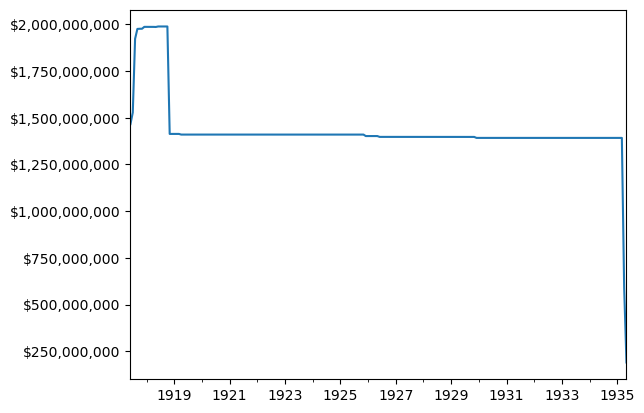

In [118]:
# For example, let's see the first liberty bond in liberty_loans
# Right now, BondQuant is date by column (which is a multiindex)
# It makes more sense (in my mind) if they were switched, so do that now
pd.options.display.float_format = '${:,.0f}'.format

BondQuant_Transposed = BondQuant.transpose()
first_liberty_series = BondQuant_Transposed.loc[(20162, 'Public Holdings')]
first_liberty_series = first_liberty_series[first_liberty_series.notna()]
ax = first_liberty_series.plot(kind="line")
ax.yaxis.set_major_formatter(lambda x, y: '${:,.0f}'.format(x))

#ax.plot(first_liberty_series.index.to_list()[17])

In [119]:
category_ids = [None, "Pre 1790 Domestic Debt", "Interest Bearing", "Non-interest bearing", "Other", "Asset"]

def get_ts_basic_info_formatted(l1_id, series_name):
    if series_name not in BondQuant_Transposed.loc[l1_id].index: return "N/C"
    series = BondQuant_Transposed.loc[(l1_id, series_name)]
    series = series[series.notna()]
    if len(series) < 1: return "N/A"
    return f"Starting at {'${:,.0f}'.format(series[0])}, ending at {'${:,.0f}'.format(series[len(series)-1])}"

def bond_quant_breakdown(l1_id):
    #first get the L1 ID level
    level = BondList.loc[l1_id, "Category L1 ID"]
    print(f"Kind: {category_ids[level]}")
    if level == 2:
        print(f"Total Outstanding: {get_ts_basic_info_formatted(l1_id, 'Total Outstanding')}")
        print(f"    Active: {get_ts_basic_info_formatted(l1_id, 'Active Outstanding')}")
        print(f"        Public: {get_ts_basic_info_formatted(l1_id, 'Public Holdings')}")
        print(f"            Coupon: {get_ts_basic_info_formatted(l1_id, 'Coupon')}")
        print(f"            Registered: {get_ts_basic_info_formatted(l1_id, 'Registered')}")
        print(f"        Intra gov: {get_ts_basic_info_formatted(l1_id, 'Intra Government Holdings')}")
        print(f"    Matured: {get_ts_basic_info_formatted(l1_id, 'Matured Outstanding')}")
        print(f"    Called: {get_ts_basic_info_formatted(l1_id, 'Called Outstanding')}")

bond_quant_breakdown(20162)

Kind: Interest Bearing
Total Outstanding: Starting at $1,466,335,094, ending at $189,928,800
    Active: Starting at $1,466,335,094, ending at $189,928,800
        Public: Starting at $1,466,335,094, ending at $189,928,800
            Coupon: Starting at $1,155,779,600, ending at $1,151,418,250
            Registered: Starting at $257,788,300, ending at $262,148,400
        Intra gov: N/A
    Matured: N/A
    Called: N/C


/var/folders/3f/77w9tyf13fvfq2c4rg1tp9x40000gn/T/ipykernel_24625/3088124787.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f"Starting at {'${:,.0f}'.format(series[0])}, ending at {'${:,.0f}'.format(series[len(series)-1])}"


In [120]:
series = BondQuant_Transposed.loc[20162, "Total Outstanding"]
series = series[series.notna()]
len(series)
series[len(series)-1]

/var/folders/3f/77w9tyf13fvfq2c4rg1tp9x40000gn/T/ipykernel_24625/1341561785.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  series[len(series)-1]


189928800.0